# **Credit card customer churn prediction**
## Team members:
### Darsi Venkata Sai Mahidhar - 20MIA1016
### Anukeerthi R - 20MIA1160

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null



Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [81.0 kB]
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x8

In [ ]:
# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# Unzip the file
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark

In [ ]:
# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'

In [ ]:
!ls

drive  sample_data  spark-3.2.1-bin-hadoop3.2  spark-3.2.1-bin-hadoop3.2.tgz


In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=acb9c94d438ce3d9c38de52f5922de6fcb0e80f8f74c7fdb46be195e7805dcce
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
import pyspark as ps
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [ ]:
from pyspark import SparkConf
from pyspark.context import SparkContext

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import corr
from pyspark.sql.functions import col, when
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
spark = SparkSession.builder.appName('CreditCardChurn').getOrCreate()

In [ ]:
data = spark.read.csv('/content/drive/MyDrive/Datasets/default of credit card clients.csv', header=True, inferSchema=True)

In [ ]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- default payment next month: inte

In [ ]:
len(data.columns)

25

In [ ]:
data.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

The UCI Machine Learning Repository Credit Card Dataset contains information on credit card customers in Taiwan from April  to September. The dataset includes demographic information, credit information, and payment history information for 30,000 credit card customers. The dataset has 25 features, which are described below:

ID: ID of each customer<br>
LIMIT_BAL: Credit limit of the customer<br>
SEX: Gender of the customer (1 = male, 2 = female)<br>
EDUCATION: Education level of the customer (1 = graduate school, 2 = university, 3 = high school, 4 = others)<br>
MARRIAGE: Marital status of the customer (1 = married, 2 = single, 3 = others)
AGE: Age of the customer<br>
PAY_0: Repayment status in September (-2 = no consumption, -1 = paid in full, 0 = use of revolving credit, 1 = payment delay for one month, 2 = payment delay for two months, …, 8 = payment delay for eight months or more)<br>
PAY_2: Repayment status in August (same scale as PAY_0)<br>
PAY_3: Repayment status in July (same scale as PAY_0)<br>
PAY_4: Repayment status in June (same scale as PAY_0)<br>
PAY_5: Repayment status in May (same scale as PAY_0)<br>
PAY_6: Repayment status in April (same scale as PAY_0)<br>
BILL_AMT1: Amount of bill statement in September<br>
BILL_AMT2: Amount of bill statement in August<br>
BILL_AMT3: Amount of bill statement in July<br>
BILL_AMT4: Amount of bill statement in June<br>
BILL_AMT5: Amount of bill statement in May<br>
BILL_AMT6: Amount of bill statement in April<br>
PAY_AMT1: Amount paid in September<br>
PAY_AMT2: Amount paid in August<br>
PAY_AMT3: Amount paid in July<br>
PAY_AMT4: Amount paid in June<br>
PAY_AMT5: Amount paid in May<br>
PAY_AMT6: Amount paid in April<br>
default payment next month: Whether or not the customer defaulted in the next month (1 = yes, 0 = no)<br>
The goal of the dataset is to predict whether a customer will default on their credit card payment in the next month, based on their demographic information, credit information, and payment history.

In [ ]:
data.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+--------------------------+
|summary|               ID|         LIMIT_BAL|               SEX|         EDUCATION|          MARRIAGE|              AGE|             PAY_0|               PAY_2|             PAY_3|               PAY_4|             PAY_5|            PAY_6|        BILL_AMT1|        BILL_AMT2|        BILL_AMT3|         BILL_AMT4|        BILL_AMT5|       BILL_AMT6|         PAY_AMT1|          PAY_AMT2|         PAY_AMT3|          PAY_AMT4|          PAY_AMT5|         PAY_AMT6|default payment next month|
+-------+-----------------+---

In [ ]:
# Check for missing values

data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()


+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  0|        0|  0|        0|       0|  0|    0|    0|    0|    0|    0|    0|        0|        0|        0|        0|        0|        0|       0|       0|       0|       0|       0|       0|                         0|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+--

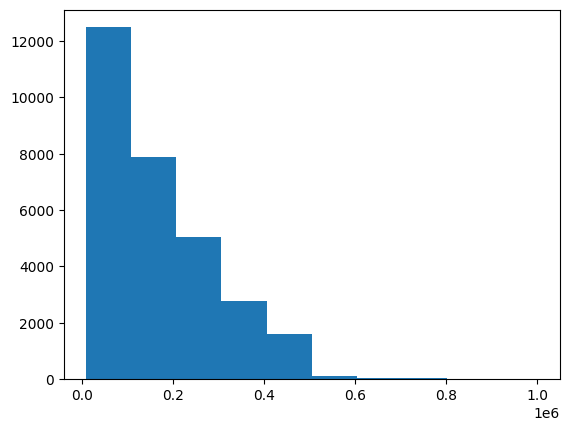

In [ ]:
# Visualize the distribution of a column
plt.hist(data.select("LIMIT_BAL").rdd.flatMap(lambda x: x).collect())
plt.show()

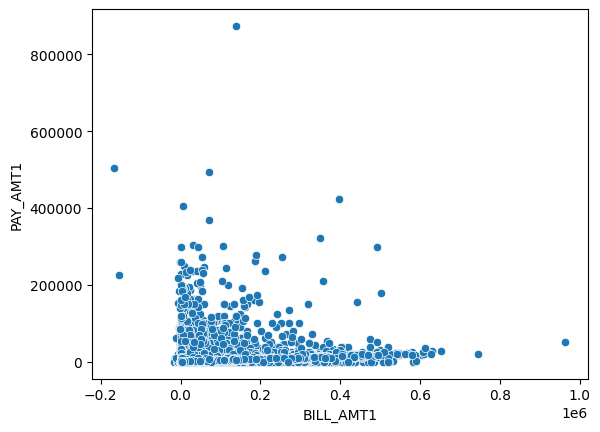

In [ ]:
# Visualize the relationship between two columns
sns.scatterplot(x="BILL_AMT1", y="PAY_AMT1", data=data.toPandas())
plt.show()

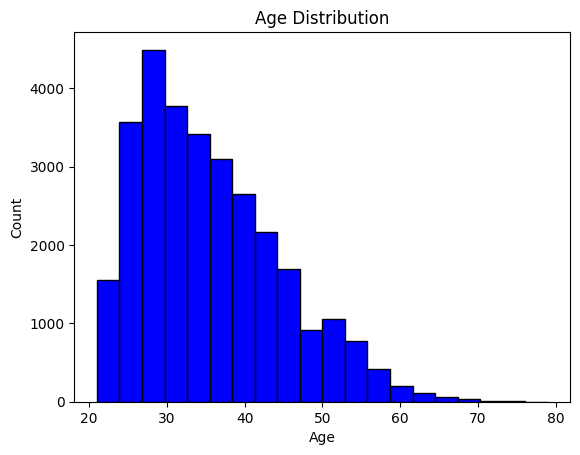

In [ ]:
# Extract the age column and convert it to a Pandas Series
age_series = data.select(col("AGE")).rdd.flatMap(lambda x: x).collect()

# Plot the age distribution using a histogram
plt.hist(age_series, bins=20, color="blue", edgecolor="black")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()

we can see the age distribution is left skewed which tell3

In [ ]:
# Map the data to (key, value) pairs where the key is the "SEX" column and the value is 1
mapped_data = data.rdd.map(lambda x: (x.SEX, 1))

# Reduce the data by summing up the values for each key
reduced_data = mapped_data.reduceByKey(lambda x, y: x + y)

# Convert the reduced data back to a DataFrame
result_df = reduced_data.toDF(["SEX", "COUNT"])

# Print the results
result_df.show()

+---+-----+
|SEX|COUNT|
+---+-----+
|  2|18112|
|  1|11888|
+---+-----+



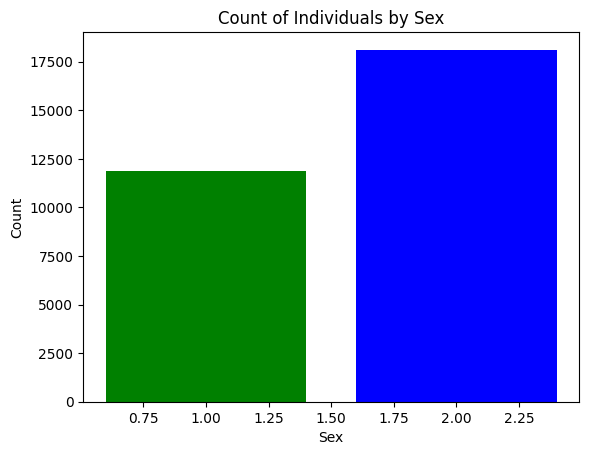

In [ ]:
import matplotlib.pyplot as plt

# Define the colors for each sex (0 = male, 1 = female)
colors = ["blue", "green"]

# Convert the DataFrame to a Pandas DataFrame for plotting
result_pd = result_df.toPandas()

# Create a bar plot with sex on the x-axis and count on the y-axis, using the defined colors
plt.bar(result_pd["SEX"], result_pd["COUNT"], color=colors)

# Add labels and title
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title("Count of Individuals by Sex")

# Show the plot
plt.show()

In [ ]:
# Map the data to (key, value) pairs where the key is the "EDUCATION" column and the value is the "LIMIT_BAL" column
mapped_data = data.rdd.map(lambda x: (x.EDUCATION, x.LIMIT_BAL))

# Reduce the data by summing up the values for each key
reduced_data = mapped_data.reduceByKey(lambda x, y: x + y)

# Convert the reduced data back to a DataFrame
result_df = reduced_data.toDF(["EDUCATION", "TOTAL_LIMIT_BAL"])

# Map the data to (key, value) pairs where the key is the "EDUCATION" column and the value is the number of occurrences of that value in the original "EDUCATION" column
counted_data = data.rdd.map(lambda x: (x.EDUCATION, 1))

# Reduce the data by summing up the values for each key
counted_data = counted_data.reduceByKey(lambda x, y: x + y)

# Convert the reduced data back to a DataFrame
counted_df = counted_data.toDF(["EDUCATION", "COUNT"])

# Join the two DataFrames on the "EDUCATION" column
joined_df = result_df.join(counted_df, "EDUCATION")

# Calculate the average limit balance by education level
avg_limit_bal_df = joined_df.withColumn("AVG_LIMIT_BAL", joined_df.TOTAL_LIMIT_BAL / joined_df.COUNT)

# Print the results
avg_limit_bal_df.show()

+---------+---------------+-----+------------------+
|EDUCATION|TOTAL_LIMIT_BAL|COUNT|     AVG_LIMIT_BAL|
+---------+---------------+-----+------------------+
|        1|     2254140000|10585|212956.06991025034|
|        2|     2063286000|14030| 147062.4376336422|
|        3|      622247680| 4917|126550.27049013626|
|        4|       84856000|  468| 181316.2393162393|
+---------+---------------+-----+------------------+



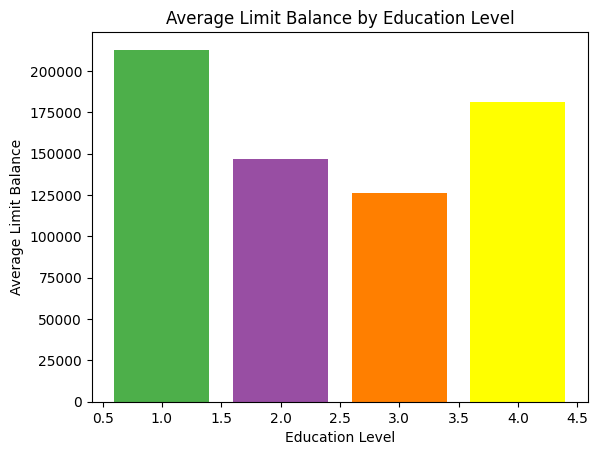

In [ ]:
import matplotlib.pyplot as plt

# Define the colors for each education level (1 = graduate school, 2 = university, 3 = high school, 4 = others)
colors = [ "#4daf4a", "#984ea3", "#ff7f00", "yellow"]

# Convert the DataFrame to a Pandas DataFrame for plotting
avg_limit_bal_pd = avg_limit_bal_df.toPandas()

# Create a bar plot with education level on the x-axis and average limit balance on the y-axis, using the defined colors
plt.bar(avg_limit_bal_pd["EDUCATION"], avg_limit_bal_pd["AVG_LIMIT_BAL"], color=colors)

# Add labels and title
plt.xlabel("Education Level")
plt.ylabel("Average Limit Balance")
plt.title("Average Limit Balance by Education Level")

# Show the plot
plt.show()


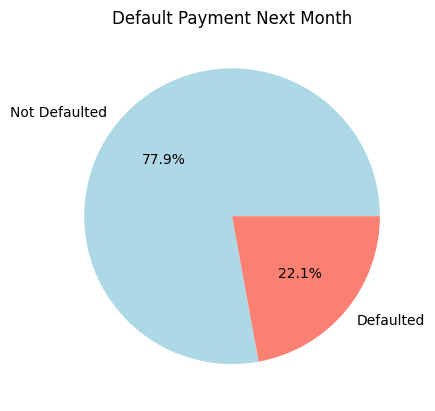

In [ ]:
# Extract the default payment next month column and convert it to a Pandas Series
default_series = data.select(col("default payment next month")).rdd.flatMap(lambda x: x).collect()

# Count the number of occurrences of each category
default_counts = [default_series.count(0), default_series.count(1)]

# Define the labels and colors for the pie chart
labels = ["Not Defaulted", "Defaulted"]
colors = ["lightblue", "salmon"]

# Create the pie chart
plt.pie(default_counts, labels=labels, colors=colors, autopct="%1.1f%%")
plt.title("Default Payment Next Month")
plt.show()

Text(0.5, 1.0, 'Churn by Gender')

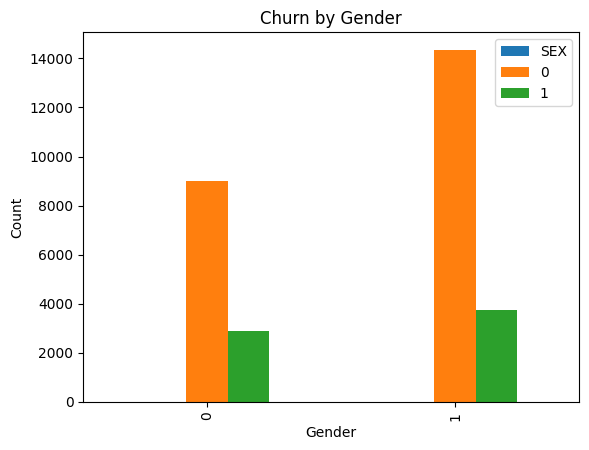

In [ ]:
grouped = data.groupby(['SEX', 'default payment next month']).agg(count('ID').alias('count')).orderBy('SEX', 'default payment next month')

gender_churn_count = grouped.groupBy('SEX').pivot('default payment next month').sum('count').orderBy('SEX').toPandas()

gender_churn_count.plot(kind='bar', stacked=False)

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Churn by Gender')


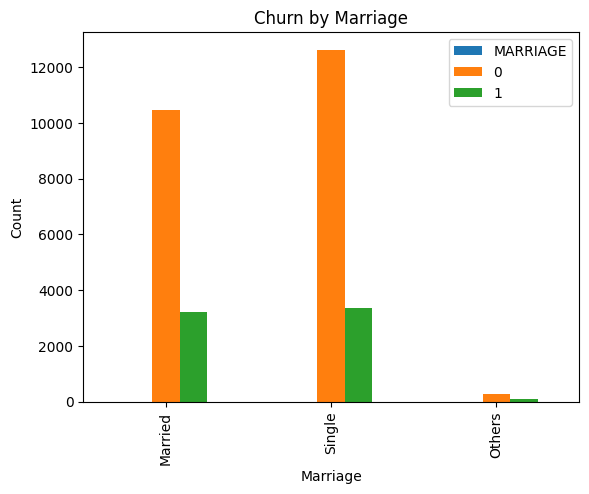

In [ ]:
import matplotlib.pyplot as plt

# Group the data by marriage status and churn, and count the number of records for each group
grouped = data.groupby(['MARRIAGE', 'default payment next month']).agg(count('ID').alias('count')).orderBy('MARRIAGE', 'default payment next month')

# Pivot the data to create a DataFrame showing the count of churned and non-churned accounts for each marriage status
marriage_churn_count = grouped.groupBy('MARRIAGE').pivot('default payment next month').sum('count').orderBy('MARRIAGE').toPandas()

# Create a bar plot with the count of churned and non-churned accounts for each marriage status
ax = marriage_churn_count.plot(kind='bar', stacked=False)

# Set the x-axis tick labels to "Married", "Single", and "Others"
ax.set_xticklabels(['Married', 'Single', 'Others'])

# Add labels and title
plt.xlabel('Marriage')
plt.ylabel('Count')
plt.title('Churn by Marriage')

# Show the plot
plt.show()


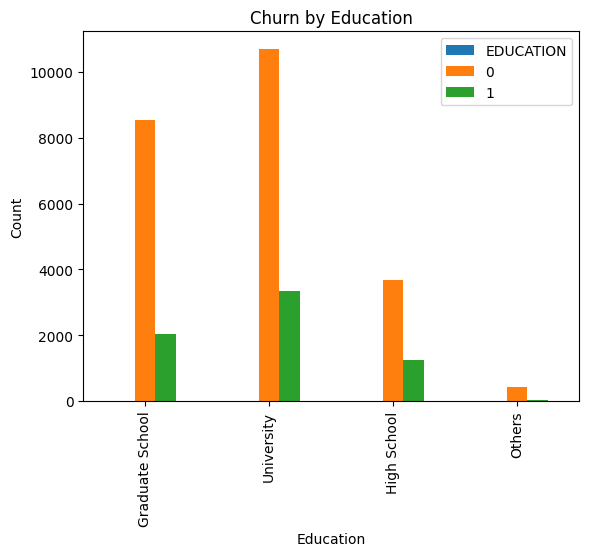

In [ ]:
import matplotlib.pyplot as plt

# Group the data by education level and churn, and count the number of records for each group
grouped = data.groupby(['EDUCATION', 'default payment next month']).agg(count('ID').alias('count')).orderBy('EDUCATION', 'default payment next month')

# Pivot the data to create a DataFrame showing the count of churned and non-churned accounts for each education level
education_churn_count = grouped.groupBy('EDUCATION').pivot('default payment next month').sum('count').orderBy('EDUCATION').toPandas()

# Create a bar plot with the count of churned and non-churned accounts for each education level
ax = education_churn_count.plot(kind='bar', stacked=False)

# Set the x-axis tick labels to "Graduate School", "University", "High School", and "Others"
ax.set_xticklabels(['Graduate School', 'University', 'High School', 'Others'])

# Add labels and title
plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Churn by Education')

# Show the plot
plt.show()


In [ ]:
data.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

<Axes: title={'center': 'Correlation with payment_default'}, xlabel='Column'>

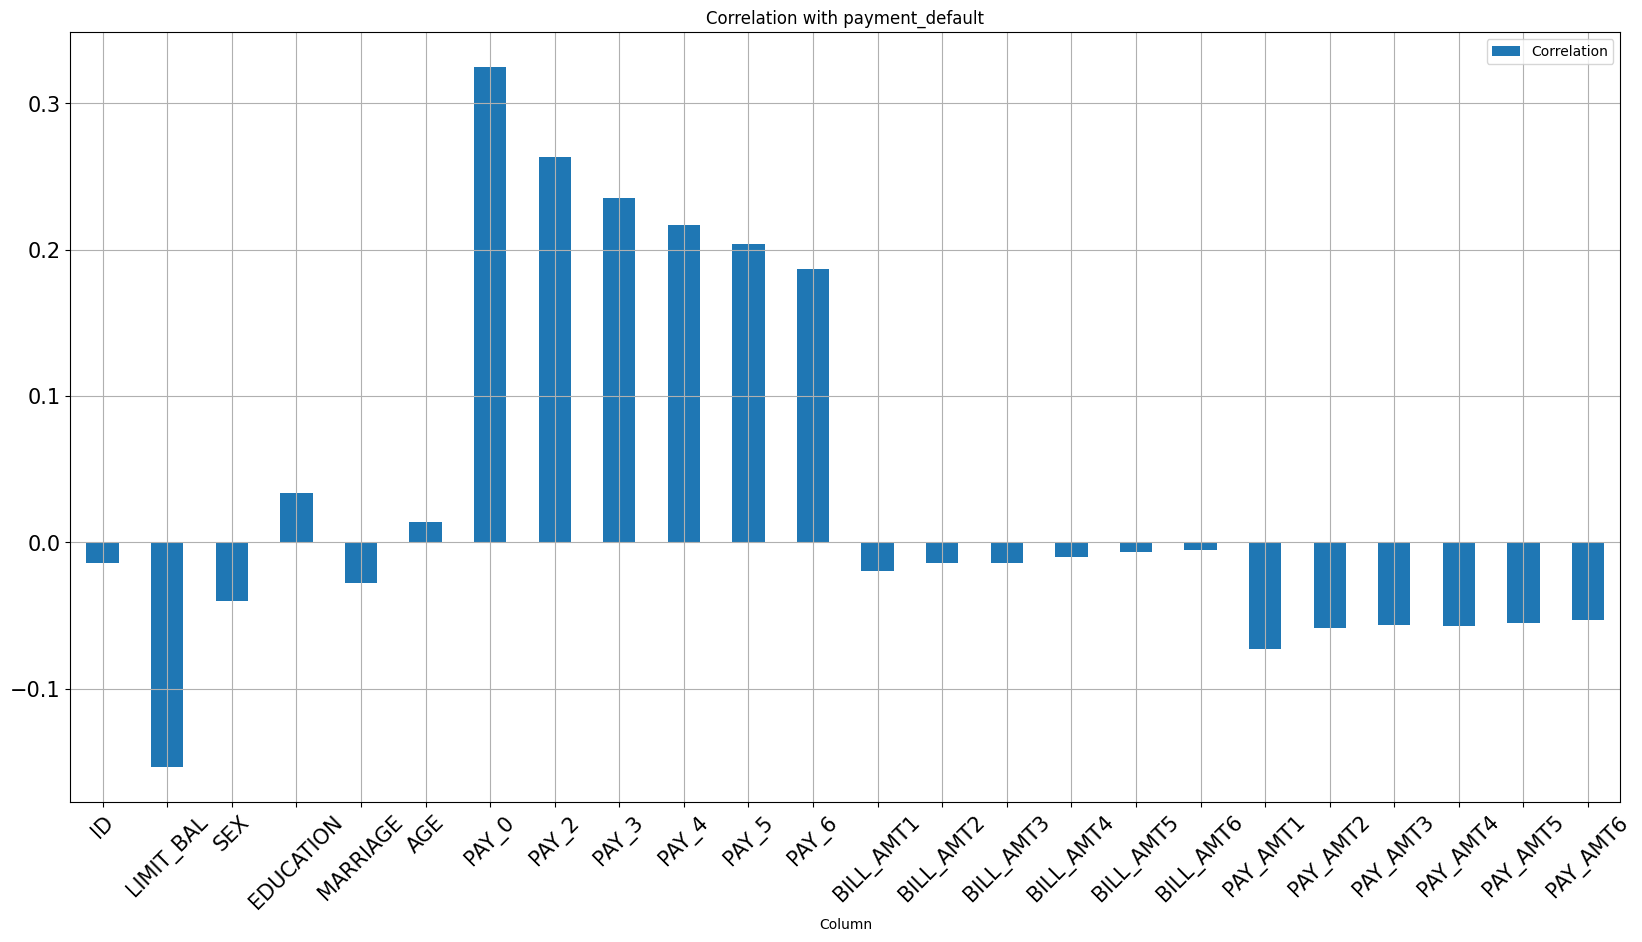

In [ ]:


# Calculate the correlation between default 'payment next month' and all other columns
corr_values = []
for column in data.columns:
    if column != "default payment next month":
        corr_value = data.select(corr(column, "default payment next month")).collect()[0][0]
        corr_values.append((column, corr_value))

# Convert the correlation values to a DataFrame and plot them as a bar chart
corr_data = spark.createDataFrame(corr_values, ["Column", "Correlation"])
corr_data.toPandas().plot.bar(x="Column", y="Correlation", figsize=(20,10), fontsize=15, rot=45, grid=True, title="Correlation with payment_default")

In [ ]:
data = data.withColumnRenamed("pay_0", "pay_1").withColumnRenamed("default payment next month", "default_pay")

In [ ]:
pay_status_columns = [f"pay_{x}" for x in range(1,7)]
bill_amt_columns = [f"bill_amt{x}" for x in range(1,7)]
pay_amt_columns = [f"pay_amt{x}" for x in range(1,7)]

In [ ]:
print('\npay  Columns Statistics')
data.select(pay_status_columns).describe().show()


pay  Columns Statistics
+-------+------------------+--------------------+------------------+--------------------+------------------+-----------------+
|summary|             pay_1|               pay_2|             pay_3|               pay_4|             pay_5|            pay_6|
+-------+------------------+--------------------+------------------+--------------------+------------------+-----------------+
|  count|             30000|               30000|             30000|               30000|             30000|            30000|
|   mean|           -0.0167|-0.13376666666666667|           -0.1662|-0.22066666666666668|           -0.2662|          -0.2911|
| stddev|1.1238015279973335|  1.1971859730345495|1.1968675684465686|  1.1691386224023357|1.1331874060027525|1.149987625607897|
|    min|                -2|                  -2|                -2|                  -2|                -2|               -2|
|    max|                 8|                   8|                 8|                  

In [ ]:
print('\nBill Amount Columns Statistics')
data.select(bill_amt_columns).describe().show()


Bill Amount Columns Statistics
+-------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+
|summary|        bill_amt1|        bill_amt2|        bill_amt3|         bill_amt4|        bill_amt5|       bill_amt6|
+-------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+
|  count|            30000|            30000|            30000|             30000|            30000|           30000|
|   mean|       51223.3309|49179.07516666667|       47013.1548| 43262.94896666666|40311.40096666667|      38871.7604|
| stddev|73635.86057552966|71173.76878252832|69349.38742703677|64332.856133916444|60797.15577026471|59554.1075367459|
|    min|          -165580|           -69777|          -157264|           -170000|           -81334|         -339603|
|    max|           964511|           983931|          1664089|            891586|           927171|          961664|
+-------+---------------

In [ ]:
print('\npay Amount Columns Statistics')
data.select(pay_amt_columns).describe().show()


pay Amount Columns Statistics
+-------+-----------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|         pay_amt1|          pay_amt2|         pay_amt3|          pay_amt4|          pay_amt5|         pay_amt6|
+-------+-----------------+------------------+-----------------+------------------+------------------+-----------------+
|  count|            30000|             30000|            30000|             30000|             30000|            30000|
|   mean|        5663.5805|         5921.1635|        5225.6815| 4826.076866666666| 4799.387633333334|5215.502566666667|
| stddev|16563.28035402577|23040.870402057186|17606.96146980311|15666.159744032062|15278.305679144742|17777.46577543531|
|    min|                0|                 0|                0|                 0|                 0|                0|
|    max|           873552|           1684259|           896040|            621000|            426529|           528666|
+

In [ ]:
data.show(2)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|pay_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default_pay|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|          1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|     3455|     3261|       0|    1000|    1000|    1000|      

In [ ]:
data.columns

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'pay_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default_pay']

In [ ]:
df = data
# Select the columns to plot
cols = [
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'pay_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default_pay']


/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


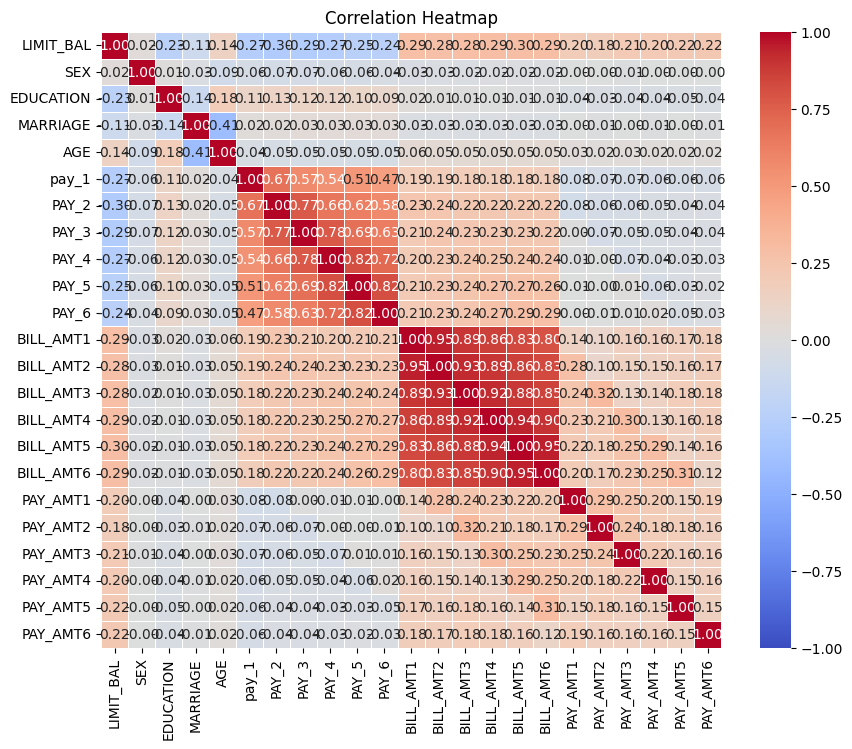

In [ ]:
# Create a vector assembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=cols[:-1], outputCol='features')

# Transform the data using the vector assembler
df_features = assembler.transform(df).select('features', 'default_pay')

# Compute the correlation matrix
corr_matrix = Correlation.corr(df_features, 'features').head()[0]

# Convert the correlation matrix to a Pandas DataFrame for plotting
corr_df = pd.DataFrame(corr_matrix.toArray(), index=cols[:-1], columns=cols[:-1])

# Plot the heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap')
sns.heatmap(corr_df, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5, vmin=-1, vmax=1)
plt.show()


In [ ]:

# Convert PySpark DataFrame to pandas DataFrame
pandas_df = df.toPandas()

# Calculate the average of the selected columns using pandas
cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
bill_avg = pandas_df[cols].mean(axis=1)

# Concatenate the resulting column with the original dataframe
df_with_bill_avg = df.withColumn('BILL_AMT_AVG', F.array([F.lit(x) for x in bill_avg]))

# Show the resulting dataframe
df_with_bill_avg.show(5)


+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+--------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|pay_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default_pay|        BILL_AMT_AVG|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+--------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|          1|[1284.0, 2846.166...|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     172

In [ ]:
bill_avg
df = df.withColumn("bill_avg", F.array(*[F.lit(x) for x in bill_avg]))
df.show(3)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+--------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|pay_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default_pay|            bill_avg|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+--------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|          1|[1284.0, 2846.166...|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     172

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/Datasets/default of credit card.csv', header=True, inferSchema=True)

In [ ]:
df = df.drop(*["ID","BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"])

In [ ]:
df.show()

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+--------+--------+--------+--------+--------+--------+--------------------------+------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|avg_bill_amt|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+--------+--------+--------+--------+--------+--------+--------------------------+------------+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|       0|     689|       0|       0|       0|       0|                         1|      1284.0|
|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|       0|    1000|    1000|    1000|       0|    2000|                         1| 2846.166667|
|    90000|  2|        2|       2| 34|    0|    0|    0|    0|    0|    0|    1518|    1500|    1000|    1000|    1000|    5000|                         0|

In [ ]:
df = df.withColumn("credit_utilization", col("avg_bill_amt") / col("LIMIT_BAL"))

In [ ]:
df.columns

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'avg_bill_amt',
 'credit_utilization']

# Logistic regression pyspark

In [ ]:
# Import the MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select the desired columns
selected_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt','credit_utilization', 'default payment next month']
df = df.select(selected_cols)

# Define the input and output columns
input_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt','credit_utilization']
output_col = 'default payment next month'

# Create a VectorAssembler to combine the input columns into a single vector column
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Transform the dataset using the VectorAssembler
df = assembler.transform(df)

In [ ]:


# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# Create a logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol=output_col)

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions_lr = lr_model.transform(test_data)

# Evaluate the model using the area under the ROC curve
evaluator = BinaryClassificationEvaluator(labelCol=output_col, metricName="areaUnderROC")
auc = evaluator.evaluate(predictions_lr)
print("AUC: ", auc)

# Evaluate the model accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=output_col, metricName="accuracy")
accuracy = evaluator.evaluate(predictions_lr)
print("Accuracy: ", accuracy)


AUC:  0.7172420874006032
Accuracy:  0.8104509343180039


# logistic regression ML


In [ ]:
import pandas as pd
df1= pd.read_csv('/content/drive/MyDrive/Datasets/default of credit card.csv')

In [ ]:
# Import the necessary libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Select the desired columns and define the input and output columns
selected_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt', 'default payment next month']
df1 = df1[selected_cols]

input_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt']
output_col = 'default payment next month'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df1[input_cols], df1[output_col], test_size=0.3, random_state=100)

# Scale the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit a logistic regression model to the training data
lr = LogisticRegression(max_iter=10, C=0.3, penalty='elasticnet', l1_ratio=0.8, solver='saga')
model = lr.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print("Test Area Under ROC: " + str(auc))

from sklearn.metrics import accuracy_score

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))



Test Area Under ROC: 0.7259996764549828
Accuracy: 80.38%


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


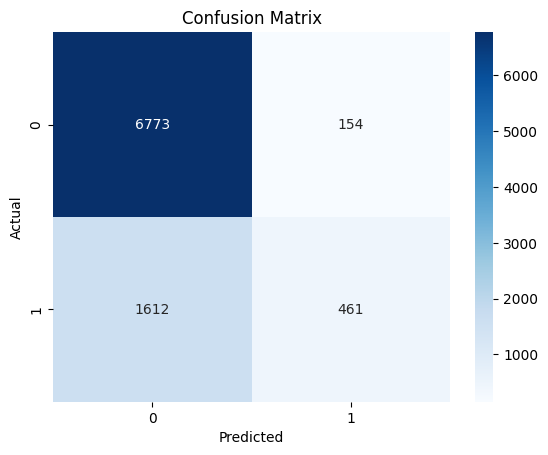


 
 CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.81      0.98      0.88      6927
           1       0.75      0.22      0.34      2073

    accuracy                           0.80      9000
   macro avg       0.78      0.60      0.61      9000
weighted avg       0.79      0.80      0.76      9000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("\n \n CLASSIFICATION REPORT" )
print(classification_report(y_test, y_pred))


# Multi Layer Perceptron using PYSPARK

In [ ]:
# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# Define the layers for the multilayer perceptron classifier
layers = [len(input_cols), 50, 20, 10, 2]

# Create the multilayer perceptron classifier
mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol=output_col, layers=layers, seed=42)

# Fit the model to the training data
mlp_model = mlp.fit(train_data)

# Make predictions on the test data
predictions_mlp = mlp_model.transform(test_data)

# # Evaluate the model using the area under the ROC curve
# evaluator = BinaryClassificationEvaluator(labelCol=output_col, metricName="areaUnderROC")
# auc = evaluator.evaluate(predictions_mlp)

# print("AUC: ", auc)


# Evaluate the model accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=output_col, metricName="accuracy")
accuracy = evaluator.evaluate(predictions_mlp)
print("Accuracy: ", accuracy)


Accuracy:  0.7811346089291709


# MLP using SKLEARN

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Select the desired columns and define the input and output columns
selected_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt', 'default payment next month']
df1 = df1[selected_cols]
input_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt']
output_col = 'default payment next month'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df1[input_cols], df1[output_col], test_size=0.3, random_state=42)

# Create the MLPClassifier model with 4 layers of size 50, 20, 10 and 2
mlp = MLPClassifier(hidden_layer_sizes=(50, 20, 10, 2), activation='relu', solver='adam', random_state=42)

# Fit the model to the training data
mlp.fit(X_train, y_train)

# Make predictions on the test data
y_pred = mlp.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7822222222222223


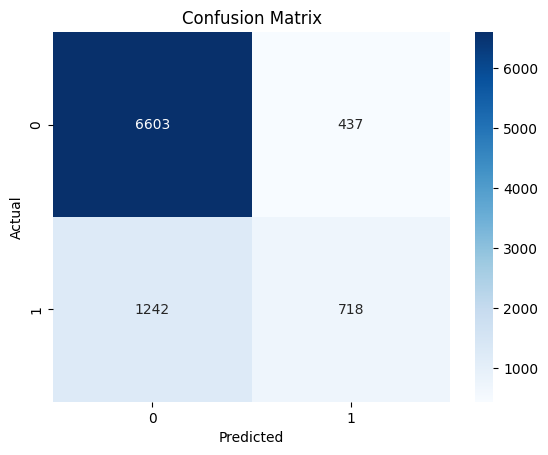


 
 CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.62      0.37      0.46      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("\n \n CLASSIFICATION REPORT" )
print(classification_report(y_test, y_pred))


## Random forest using PYSPARK

In [ ]:
# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)
# Creating random forest classifier model
rf = RandomForestClassifier(labelCol='default payment next month', featuresCol='features', numTrees=50)
# fitting the model
model = rf.fit(train_data)
# Make predictions on test data
predictions_rf = model.transform(test_data)
# Evaluvate the model using the area under the ROC curve
evaluator = BinaryClassificationEvaluator(labelCol='default payment next month')
auc = evaluator.evaluate(predictions_rf)
# Printing the accuracy
print('Area under ROC curve: ', auc)
# Evaluate the model accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=output_col, metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)
print("Accuracy: ", accuracy)

Area under ROC curve:  0.7696376214258451
Accuracy:  0.8220879489761665


# Random Forest using SKLEARN

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Select the desired columns and define the input and output columns
selected_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt', 'default payment next month']
df1 = df1[selected_cols]

input_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt']
output_col = 'default payment next month'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df1[input_cols], df1[output_col], test_size=0.3, random_state=42)

# Creating random forest classifier model
rf = RandomForestClassifier(n_estimators=50)

# fitting the model
model = rf.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Printing the accuracy
print('Accuracy of Random Forest Classifier: ', accuracy)


Accuracy of Random Forest Classifier:  0.8134444444444444


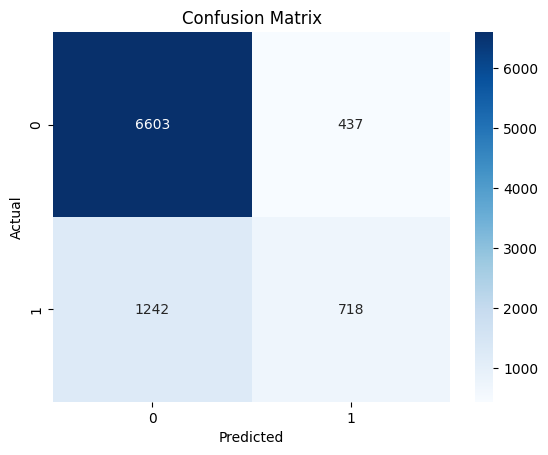


 
 CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.62      0.37      0.46      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("\n \n CLASSIFICATION REPORT" )
print(classification_report(y_test, y_pred))


# Gradient boost trees in PYSPARK

In [ ]:


# Select the desired columns
selected_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt', 'default payment next month']
df = df.select(selected_cols)

# Define the input and output columns
input_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt']
output_col = 'default payment next month'

# Create a VectorAssembler to combine the input columns into a single vector column
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Transform the dataset using the VectorAssembler
df = assembler.transform(df)

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# Create a Gradient Boosted Trees (GBT) model
gbt = GBTClassifier(labelCol=output_col, featuresCol="features")

# Define a grid of hyperparameters to search over using cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 5, 10]) \
    .addGrid(gbt.maxBins, [10, 20, 40]) \
    .addGrid(gbt.maxIter, [10, 50, 100]) \
    .build()

# Define an evaluator for binary classification
evaluator = BinaryClassificationEvaluator(labelCol=output_col)

# Define the cross-validator
cv = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(train_data)

# Make predictions on the test data
predictions = cv_model.transform(test_data)

# Evaluate the model's performance on the test data
auc = evaluator.evaluate(predictions)
print("Area Under ROC: {:.3f}".format(auc))


Area Under ROC: 0.779


# GBT in SKLEARN

In [ ]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
# Select the desired columns and define the input and output columns
selected_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt', 'default payment next month']
df1 = df1[selected_cols]

input_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'avg_bill_amt']
output_col = 'default payment next month'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df1[input_cols], df1[output_col], test_size=0.3, random_state=42)

# Create and fit the Gradient Boosting Tree model
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
gbc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gbc.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Print the classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.821
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7040
           1       0.67      0.36      0.47      1960

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000



In [ ]:
# Generate predictions on the test set
y_pred = model.predict_proba(X_test)[:, 1]

# Calculate AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)

print(f"AUC: {auc:.4f}")


AUC: 0.7545


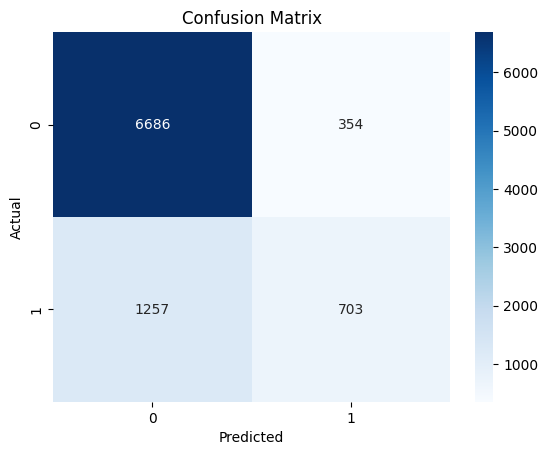

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()